In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
# Read gene expression file
df = pd.read_csv("./gene_expression.txt", sep="\t")
df = df.set_index('gene')

df.head()

,A1-PrimT_ROi_CP-2535,A1-1-R-LUNG-MET_ROi_CP-2536,A1-10-ADREN_MET_ROi_CP-2538,A1-13-LIVER-MET_ROi_CP-2539,A1-4-SPIN-MET_ROi_CP-2537,A1-AxLN-Met-R0i_CP-1163,A1-AxLN-Met_ROi_CP-2540,A2-PrimT-FFPER0i_CP-1365,A2-LN-Met-subcarinall--R0i_CP-1164,A2-LungMet-R0i_CP-1165,...,A16-2-LivN-110855-2R0i_CP-2768,A17-2-LivN-111079-2R0i_CP-2769,A19-LivN-120715-2R0i_CP-2770,A20-LivN-120769-2R0i_CP-2772,A21-LivN-120915-2R0i_CP-2773,A25-LivN-130387-1R0i_CP-2766,A38-LivN-R-150306-1R0i_CP-2767,A4-Breast-NL-R0i_CP-3047,9830-010214A-R0i_CP-3045,9830-020185A-R0i_CP-3046
gene,,,,,,,,,,,,,,,,,,,,,
DDX11L1,104.69500,81.199,65.66020,113.41500,152.589,23.6021,40.4755,5.60542,8.06425,0.000,...,0.004559,4.20897,22.829,2.83510,0.000,0.00000,3.37248,27.2918,52.79120,81.9235
WASH7P,1201.66700,939.799,472.10500,1254.15800,1469.460,348.1300,612.0960,24.68440,1180.34700,314.165,...,1037.043000,617.81300,956.174,691.31600,1098.807,1160.28700,560.77500,2109.0400,2961.72800,3560.1090
MIR6859-3,0.00000,0.000,0.00000,0.00000,0.000,0.0000,0.0000,0.00000,0.00000,0.000,...,0.000000,0.00000,0.000,0.00000,0.000,0.00000,0.00000,0.0000,0.00000,0.0000
RP11-34P13.3,1.72026,0.000,4.05717,4.93137,0.000,0.0000,0.0000,0.00000,0.00000,0.000,...,5.246680,0.00000,0.000,2.09847,0.000,1.04016,0.00000,0.0000,1.08301,0.0000
MIR1302-9,0.00000,0.000,0.00000,0.00000,0.000,0.0000,0.0000,0.00000,0.00000,0.000,...,0.000000,0.00000,0.000,0.00000,0.000,0.00000,0.00000,0.0000,0.00000,0.0000


In [3]:
def classify_site(sample_name: str):
    """
    Classify the site where we have gene expression data.
    
    It may be from a primary, lung, adrenal, etc. tissue
    And may or may not have metasticized.
    """
    name = sample_name.upper()

    if "PRIM" in name or "PRI" in name:
        return "primary"
    if "LUNG" in name:
        return "lung"
    if "ADREN" in name:
        return "adrenal"
    if "LIVER" in name or "LIV" in name:
        return "liver"
    if "BRAIN" in name:
        return "brain"
    if "PLEURA" in name:
        return "pleura"
    if "PANCREAS" in name:
        return "pancreas"
    if "LYMPH" in name:
        return "lymph"
    if "RIB" or "SPIN" in name:
        return "bone"
    
def classify_meta(name):
    return "MET" in name

meta = pd.DataFrame({ "sample": df.columns, "site": df.columns.map(classify_site), "met": df.columns.map(classify_meta) })

meta.head()

,sample,site,met
0,A1-PrimT_ROi_CP-2535,primary,False
1,A1-1-R-LUNG-MET_ROi_CP-2536,lung,True
2,A1-10-ADREN_MET_ROi_CP-2538,adrenal,True
3,A1-13-LIVER-MET_ROi_CP-2539,liver,True
4,A1-4-SPIN-MET_ROi_CP-2537,bone,True


In [99]:
keys = df.index

mt1_ref_genes = [
"MT1L",
"MT1E",
"MT1M",
"MT1JP",
"MT1A",
"MT1DP",
"MT1CP",
"MT1B",
"MT1F",
"MT1G",
"MT1H",
"MT1X"
]

mmp_ref_genes = [
    # "MMP1","MMP2","MMP3","MMP7","MMP8","MMP9","MMP10","MMP11",
    # "MMP12","MMP13","MMP14","MMP15","MMP16","MMP17","MMP19","MMP20",
    # "MMP21","MMP23","MMP24","MMP25","MMP26","MMP27","MMP28"
    "MMP2"
]
epi_ref_genes = [
    "CDH1","OCLN","EPCAM","CLDN3","CLDN4"
]
mes_ref_genes = [
    "VIM","ZEB1","ZEB2","SNAI1","SNAI2","TWIST1","FN1","CDH2"
]
bone_ref_genes = ["CXCR4", "IL11", "VCAM1", "MMP1"]
lung_ref_genes = ["ANGPTL4", "VCAM1", "MMP7", "ITGA6"]
liver_ref_genes = ["IL6", "VEGFA", "CXCL12", "MMP9"]
mitos_ref_genes = ["ADAM10", "JUN", "FOS"]


[mmp_genes, epi_genes, mes_genes,
     bone_genes, lung_genes, liver_genes, mt1_genes, mitos_genes] = [
    [gene for gene in genes if gene in keys] for genes in
    [mmp_ref_genes, epi_ref_genes, mes_ref_genes,
     bone_ref_genes, lung_ref_genes, liver_ref_genes, mt1_ref_genes, mitos_ref_genes]
]

# z-score normalize each gene
z = df.apply(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0, axis=1)

MES_level = z.loc[mes_genes].mean()
EPI_level = z.loc[epi_genes].mean()
MT1_level = z.loc[mt1_genes].mean()

EMT_score = (
    MES_level - 
    EPI_level
)

MMP_score = z.loc[mmp_genes].mean()

mitos_score = z.loc[mitos_genes].mean()

# These are bond, lung, liver metastasis genes
bone_score = z.loc[bone_genes].mean()
lung_score = z.loc[lung_genes].mean()
liver_score = z.loc[liver_genes].mean()

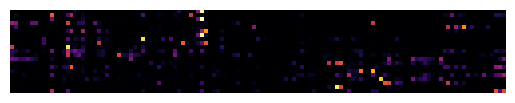

(array([48, 14, 10, 82, 91]),
 Index(['A17-9ChestMet_ROi_CP-2571', 'A5-PrimT030065B_ROi_CP-2545',
        'A4-PrimT020306B__ROi_CP-2542', 'A28-LungMet-RUL_ROi_CP-2590',
        'A31-PrimT-FFPER0i_CP-1363'],
       dtype='object'),
 array([2.0147112 , 1.57923439, 0.87997079, 0.74837718, 0.71773766]))

In [77]:
# Sort and figure out which genes have most significant difference
arr = np.array(z.loc[mmp_genes])

plt.imshow(arr, cmap="inferno", vmin=0, vmax=10)
plt.axis("off")
plt.show()

# Select the top 5 tissues with really high scores on this for further analysis
top_people = arr.mean(axis=0)
top_five = np.argsort(-top_people)[:5]
# Find the names of these tissues
column_names = df.columns[top_five]

top_five, column_names, top_people[top_five]

In [ ]:
# Perform KNN and find most significant sites that determine difference between locations


In [19]:
meta["site"], EMT_score

(0      primary
 1         lung
 2      adrenal
 3        liver
 4         bone
         ...   
 120      liver
 121      liver
 122       bone
 123       bone
 124       bone
 Name: site, Length: 125, dtype: object,
 A1-PrimT_ROi_CP-2535              45745.805852
 A1-1-R-LUNG-MET_ROi_CP-2536       44713.755945
 A1-10-ADREN_MET_ROi_CP-2538        2501.282473
 A1-13-LIVER-MET_ROi_CP-2539       34175.720914
 A1-4-SPIN-MET_ROi_CP-2537         33597.298173
                                       ...     
 A25-LivN-130387-1R0i_CP-2766      16062.890117
 A38-LivN-R-150306-1R0i_CP-2767    27685.035095
 A4-Breast-NL-R0i_CP-3047          41319.883272
 9830-010214A-R0i_CP-3045          26469.662840
 9830-020185A-R0i_CP-3046          24883.464200
 Length: 125, dtype: float64)

In [100]:
data = pd.DataFrame({
    "met": list(meta["met"]),
    "site": list(meta["site"]),
    "epi": EPI_level,
    "mes": MES_level,
    "mt1": MT1_level,
    "emt": EMT_score,
    "mmp": MMP_score,
    "lung": lung_score,
    "bone": bone_score,
    "liver": liver_score,
    "mitosis": mitos_score
})

data.head()

,met,site,epi,mes,mt1,emt,mmp,lung,bone,liver,mitosis
A1-PrimT_ROi_CP-2535,False,primary,1.397611,0.255374,0.774201,-1.142238,0.185431,1.424095,0.180766,-0.065954,0.132496
A1-1-R-LUNG-MET_ROi_CP-2536,True,lung,0.849065,0.327012,0.629261,-0.522053,0.657056,1.491096,0.417969,0.165783,0.613164
A1-10-ADREN_MET_ROi_CP-2538,True,adrenal,0.464478,-0.497968,-0.240346,-0.962446,-0.442525,0.281535,-0.188487,0.317695,-0.349947
A1-13-LIVER-MET_ROi_CP-2539,True,liver,1.086381,-0.096625,-0.011495,-1.183006,-0.406623,1.156569,0.073214,0.532887,0.081082
A1-4-SPIN-MET_ROi_CP-2537,True,bone,1.056401,-0.106045,-0.161816,-1.162446,-0.353855,0.801638,0.600922,0.874988,0.046266


P value: 0.012023538171478906


/tmp/ipykernel_7386/2965709225.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="site", y=type_to_plot, data=data, palette="PRGn")


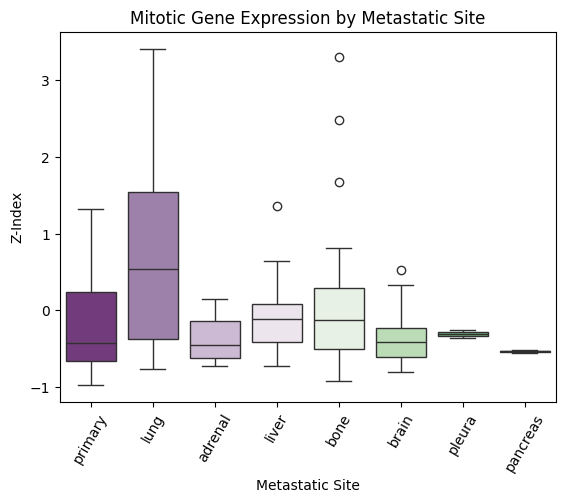

In [ ]:
type_to_plot = "mmp"

t_statistic, p_value = stats.ttest_ind(
    data[list(meta["site"] == "primary")][type_to_plot],
    data[list(meta["site"] == "lung")][type_to_plot]
)

print("P value:", p_value)

sns.boxplot(x="site", y=type_to_plot, data=data, palette="PRGn")

# sns.stripplot(data=data, x="site", y=type_to_plot,
            #   hue="met", hue_order=[True, False], dodge=True)

plt.title("Mitotic Gene Expression by Metastatic Site")
plt.ylabel("Z-Index")
plt.xlabel("Metastatic Site")
plt.xticks(rotation=60)
plt.show()

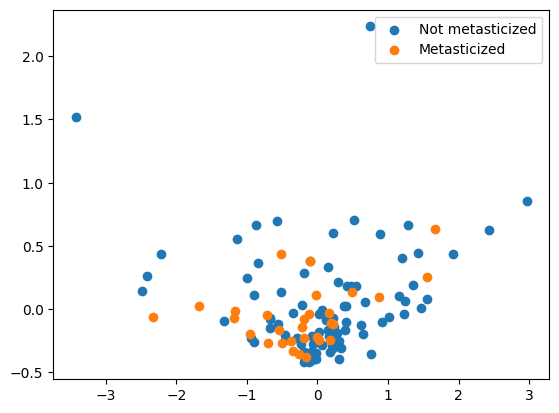

In [ ]:

plt.scatter(data[data["met"] == False]["emt"], data[data["met"] == False]["mmp"], label="Not metasticized")
plt.scatter(data[data["met"] == True]["emt"], data[data["met"] == True]["mmp"], label="Metasticized")
plt.legend()

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

X = np.vstack([EMT_score, MMP_score]).T

# Example: 1 if lung metastasis
y = (meta["site"] == "lung").astype(int)

model = LogisticRegression().fit(X, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)



Coefficients: [[0.23074628 0.41559119]]
Intercept: [-1.74572104]


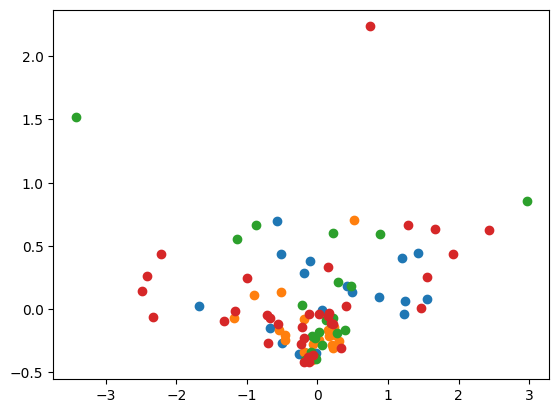

In [128]:
i_to_sites = { i: x for i, x in enumerate(list(set(meta["site"]))) }
sites_to_i = { x: i for i, x in enumerate(list(set(meta["site"]))) }

y = [sites_to_i[x] for x in meta["site"]]
X = np.vstack([EMT_score, MMP_score]).T

logit = LogisticRegression().fit(X, y)

# plt.scatter(EMT_score, MMP_score)
plt.scatter(EMT_score[list(meta["site"] == "lung")], MMP_score[list(meta["site"] == "lung")])
plt.scatter(EMT_score[list(meta["site"] == "liver")], MMP_score[list(meta["site"] == "liver")])
plt.scatter(EMT_score[list(meta["site"] == "primary")], MMP_score[list(meta["site"] == "primary")])
plt.scatter(EMT_score[list(meta["site"] == "bone")], MMP_score[list(meta["site"] == "bone")])
plt.show()
# logit.predict(X), y